<a href="https://colab.research.google.com/github/EkaSulistyawan/deep-image-prior-pam/blob/main/DIP_for_Undersampled_OR_PAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Drive

Data stored in private Google Drive. I'll provide you with some data by request!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! cp drive/MyDrive/Matlab/common_utils.py ./common_utils.py

Mounted at /content/drive


# Load necessary lib

This project uses torchvision.
It should be okay to run this script on Google Colab.

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import torch
import torch.optim

import torchvision

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = False
imsize = -1
dim_div_by = 64

from scipy.io import loadmat,savemat
import torch
import torch.nn as nn

import math

#  Visualizing Function

In [6]:
def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)

    return torch_grid.numpy()
def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid

    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"

    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)

    plt.figure(figsize=(len(images_np) + factor, 12 + factor))

    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='hot', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)

    plt.show()

    return grid

# Load Raw Data

I had my data implemented in Matlab.
This project is supposed to be a competitor for our paper: [the CS-CVT](https://ieeexplore.ieee.org/abstract/document/10115487).

The data I shared is not published, so you may use it for experiment 😀

In [4]:
folderloc = "drive/MyDrive/Matlab/"
filename = "40000_400_reg3x3_carbon2_PYTHON_TQcE8gUN"


# fileloc cell --> rawCELL-dev11
# fileloc mems --> rawMEMS
fileloc = f"{folderloc}15102022/{filename}"

0.11008724634839721


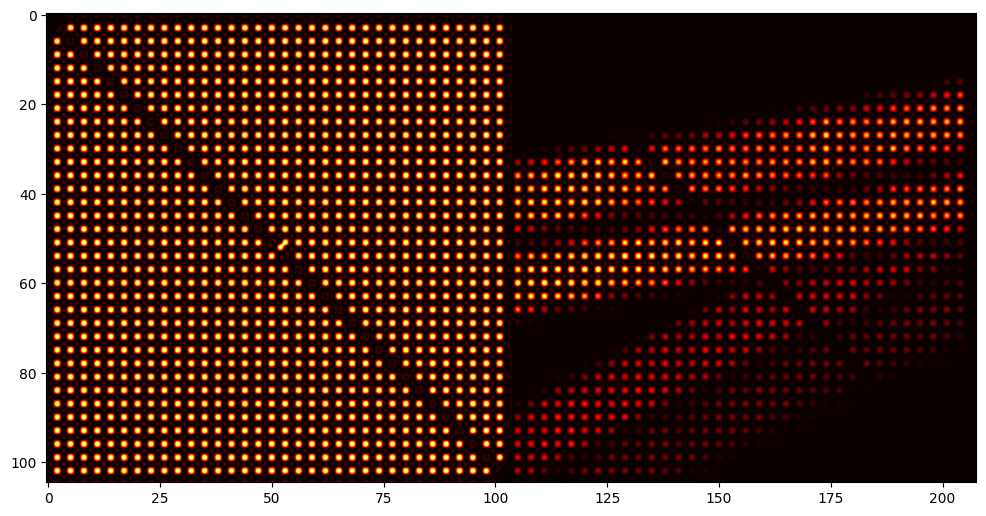

In [7]:
dat = loadmat(f"{fileloc}.mat")
img_np = np.fliplr(dat['Cmode_to_python']).T.copy()
img_mask_np = np.flipud(dat['mask_to_python']).copy()
NET_TYPE = 'myskip' # one of skip_depth4|skip_depth2|UNET|ResNet|skip_depth6|myskip

# PARAM
input_depth = 1
num_iter = 1000 # def (1) 501, (2) 1001
show_every = 50
figsize = 8
LR = 0.02  # def 0.02
net_depth = 2 # def 2
net_encoder_kernel_size=7 # def 5
net_decoder_kernel_size=5 # def 3

pad = 'reflection' # 'zero'
OPTIMIZER = 'adam'
print(img_mask_np.mean())
plot_image_grid([np.reshape(img_mask_np,(1,img_mask_np.shape[0],img_mask_np.shape[1])),np.reshape(img_np,(1,img_np.shape[0],img_np.shape[1]))], factor=10);

SKIPNET

**DOWNSAMPLE MODULE**
- PAD
- CONV
- BatchNorm
- Act Func
- PAD
- CONV
- BatchNorm
- Act Func
- *cont'd*

**UPSAMPLE MODULE**
- Upsample
- BatchNorm
- PAD
- CONV
- BatchNorm
- Act Func
- *cont'd*

**TAIL MODULE**
- PAD
- Conv
- Sigmoid

**Formula**
- Depth = N
- (N)Downsample + (N) Upsample + Tail

In [8]:
def encoder_conv(in_channel,out_channel,kernel_size=5):
    """
        Encoder with one simple layer (ReflectionPad, Conv2D, BN, AF)
    """
    padsize = kernel_size//2
    conv_instance = nn.Sequential(                                 # (400,400)
        nn.ReflectionPad2d(padsize),                               # (404,404)
        nn.Conv2d(in_channel,out_channel,kernel_size,stride=2),   # (200,200)
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2, inplace=True),
        nn.ReflectionPad2d(padsize),                               # (204,204)
        nn.Conv2d(out_channel,out_channel,kernel_size,stride=1),  # (200,200)
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2, inplace=True),
    )

    return conv_instance

def decoder_conv(in_channel,out_channel,kernel_size=3,scaling_mode='nearest',decoder_mode='Upsample'):
    """
        Decoder: mode = ConvTranspose2d|Upsample
    """
    padsize = kernel_size//2;
    if(decoder_mode=='ConvTranspose2d'):
        #upsampler = nn.ConvTranspose2d(in_channel,out_channel,)
        print("Not Yet Implemented")
    else:
        upsampler = nn.Sequential(                                    # (100,100)
            nn.Upsample(scale_factor=2,mode=scaling_mode),            # (200,200)
            nn.BatchNorm2d(in_channel),
            nn.ReflectionPad2d(padsize),                              # (204,204)
            nn.Conv2d(in_channel,out_channel,kernel_size,stride=1)    # (200,200)
        )

    conv_instance = nn.Sequential(
        upsampler,
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2, inplace=True),
    )

    return conv_instance

class myskip(nn.Module):
    def __init__(self,depth=2,num_channels=[16,32,64,128,128],encoder_kernel_size=5,decoder_kernel_size=3,imgsz = 0):
        super(myskip,self).__init__()

        encoderlist = []
        # padding if not complete
        if (imgsz%(depth**2)!=0):
            n_pad = math.ceil(imgsz/(depth**2)) * (depth**2)
            n_pad = n_pad - imgsz

            header = nn.ReflectionPad2d(n_pad//2)
            encoderlist.append(header)
            # predict end of downsampling imgsize
            bottom = math.ceil( (imgsz + 2*n_pad//2) / (2**depth) )
            upper = bottom*(2**depth)
            #####print(bottom,upper)

            # for footer
            footer_kernel =nn.Conv2d(16,1,upper-imgsz+1,stride=1) ;
        else:
            footer_kernel = nn.Conv2d(16,1,1,stride=1);

        # encoder
        encoderlist.append(encoder_conv(1,num_channels[0],kernel_size=encoder_kernel_size))
        for i in range(1,depth):
            encoderlist.append(encoder_conv(num_channels[i-1],num_channels[i],kernel_size=encoder_kernel_size))


        # decoder
        decoderlist = [decoder_conv(num_channels[depth-1],num_channels[depth-1],kernel_size=decoder_kernel_size)]
        for i in range(depth-1,0,-1):
            decoderlist.append(decoder_conv(num_channels[i],num_channels[i-1],kernel_size=decoder_kernel_size))

        self.codec =nn.Sequential(*(list(encoderlist)+list(decoderlist)))
        self.tail = nn.Sequential(
            footer_kernel,
            nn.Sigmoid()
        )

    def forward(self,x):

        x = self.codec(x)
        x = self.tail(x)

        return x


def get_noise(input_depth,spatial_size,var=0.1):
    shape = [1, input_depth, spatial_size[0], spatial_size[1]]
    net_input = torch.zeros(shape)

    net_input.uniform_()
    net_input *= var

    return net_input

def np_to_torch(x):
    return torch.from_numpy(x)[None,:]

def torch_to_np(x):
    return x.detach().cpu().numpy()[0]

In [9]:
net = myskip(depth=net_depth,encoder_kernel_size = net_encoder_kernel_size,decoder_kernel_size=net_decoder_kernel_size,imgsz = img_np.shape[0])

net = net.type(dtype)
net_input = get_noise(input_depth, img_np.shape).type(dtype)

In [10]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(np.array([img_np])).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 127809


# Main loop

In [11]:
net_input_saved = net_input.detach().clone()

if PLOT :
  img_iter = np.zeros((num_iter,img_np.shape[0],img_np.shape[1]))
else :
  img_iter = 0

for i in range(0,num_iter):
    optimizer = torch.optim.Adam([x for x in net.parameters()], lr=LR)

    optimizer.zero_grad()

    out = net(net_input)
    loss = mse(out*mask_var,img_var)
    if  PLOT and i % 10 == 0:
        out_np = torch_to_np(out)
        img_iter[i,:,:] = np.clip(out_np, 0, 1)
        #plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
    loss.backward()
    optimizer.step()

MSE: 0.00010596845822874457


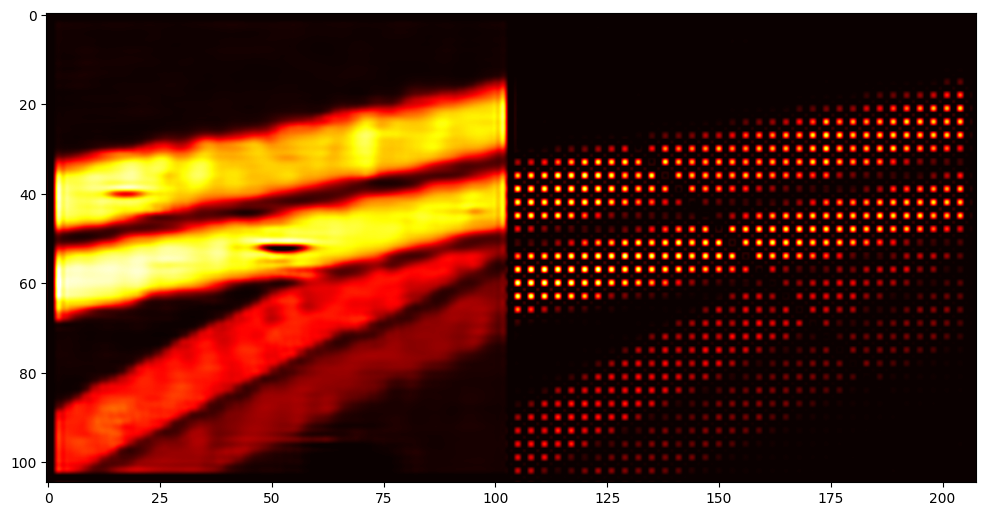

In [12]:
out_np = torch_to_np(net(net_input))
print(f"MSE: {loss.detach().cpu().numpy()}")
t = plot_image_grid([out_np,np.reshape(img_np,(out_np.shape))], factor=10);

## Save the MAT

In [13]:
# save
dat['recon_from_python'] = out_np
dat['net_iter'] = num_iter
dat['net_depth'] = net_depth
dat['net_encoder_kernel_size'] = net_encoder_kernel_size
dat['net_decoder_kernel_size'] = net_decoder_kernel_size
dat['net_LR'] = LR
dat['img_iter'] = img_iter # turn on to get video
dat['DIPMSE'] = loss.detach().cpu().numpy()

dat[NET_TYPE] = 1
dat[OPTIMIZER] = 1
savemat(f"{filename}-DIP{NET_TYPE}.mat",dat)

#  Extract CNN Value

In [14]:
net

myskip(
  (codec): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2))
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): ReflectionPad2d((3, 3, 3, 3))
      (5): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1))
      (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): ReflectionPad2d((3, 3, 3, 3))
      (5): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
      (6): BatchNorm2d(32, eps=1e-05,

In [16]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
for i in range(0,4):
    net.codec[i].register_forward_hook(get_activation(f'codec_{i}'))
    out_np = torch_to_np(net(net_input))
    #activation.keys()

In [17]:
activation['codec_1'].shape

torch.Size([1, 16, 52, 52])

0


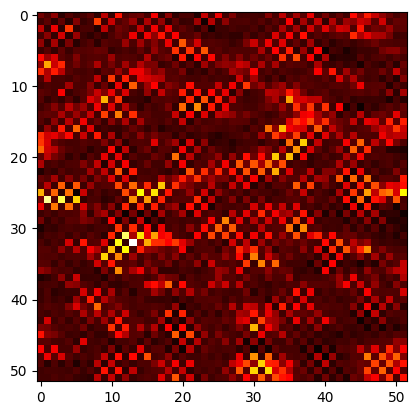

1


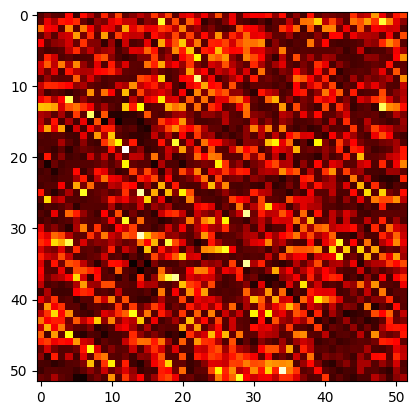

2


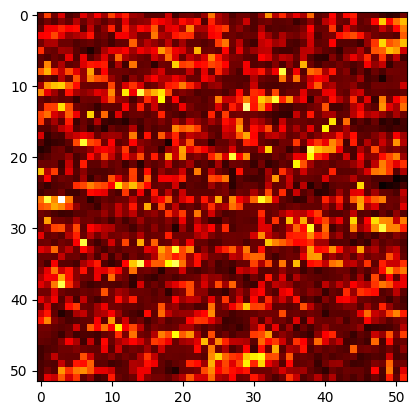

3


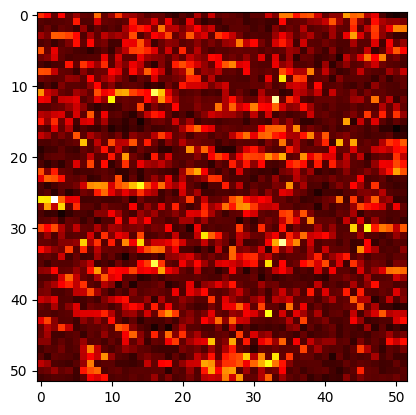

4


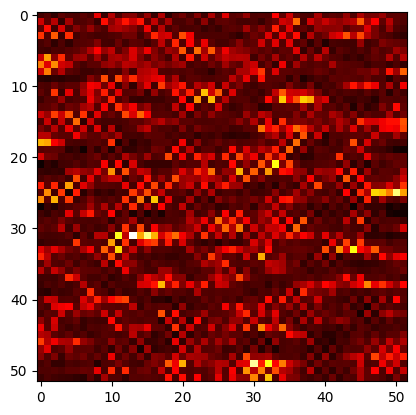

5


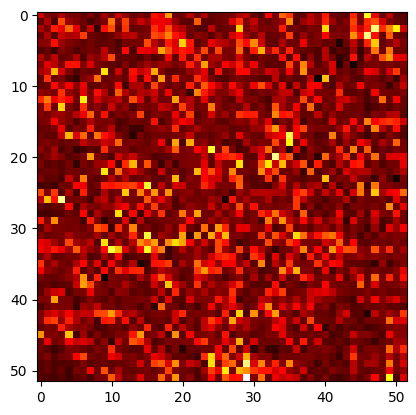

6


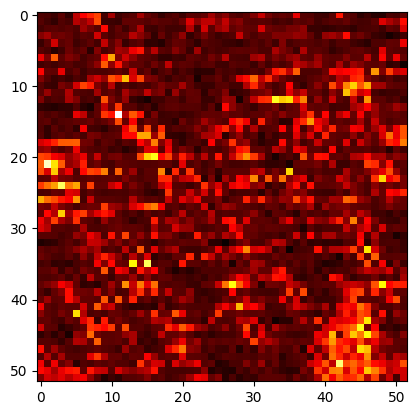

7


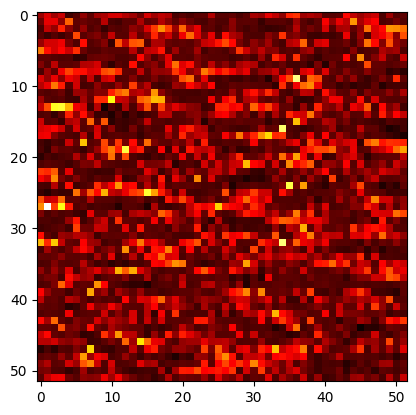

8


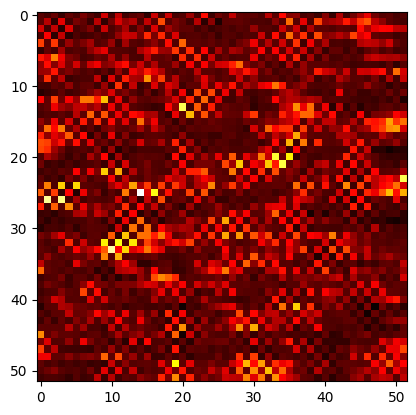

9


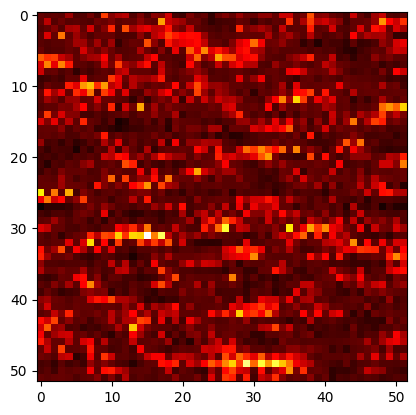

10


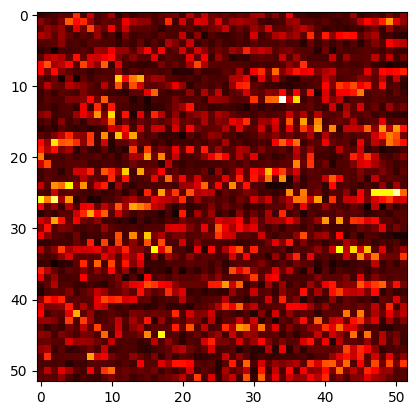

11


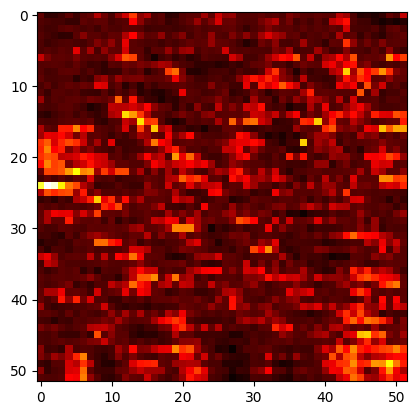

12


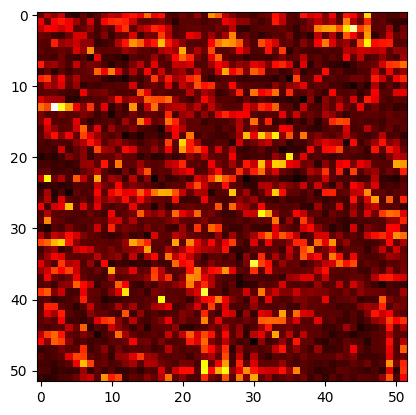

13


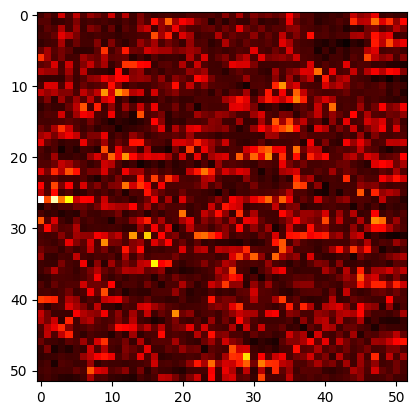

14


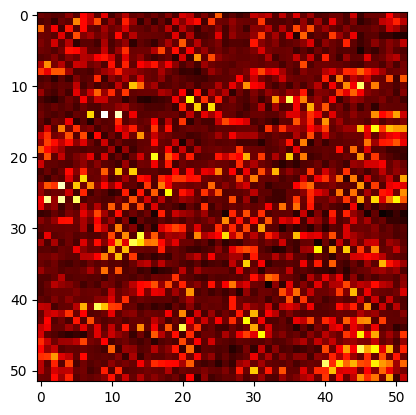

15


In [ ]:
for i in range(0,16):
    print(i)
    layer_img = torch_to_np(activation['codec_1'][:,i,:,:])
    plt.imshow(layer_img,cmap='hot')
    plt.savefig(f"codec_3_{i}.png",dpi=600)
    plt.show()